<a href="https://colab.research.google.com/github/da-roth/StableAndBiasFreeMonteCarloGreeks/blob/main/src/Examples_Introduction/example_barrier_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



In [3]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

class BarrierCall:

    # Define constants as class attributes
    t_0 = 0.0
    B = 70.0
    m = 20
    T = 1.0
    r = 0.04
    sigma = 0.3
    K = 0.1
    N = 500000

    @staticmethod
    def MC_naive_torch(s_0):
        return BarrierCall.MC_naive_generic_torch(s_0, BarrierCall.path_update_naive)

    @staticmethod
    def MC_euler_torch(s_0):
        return BarrierCall.MC_naive_generic_torch(s_0, BarrierCall.path_update_euler)

    @staticmethod
    def MC_BB_torch(s_0):
        return BarrierCall.MC_brownian_bridge_torch(s_0, BarrierCall.path_update_naive)

    @staticmethod
    def MC_BB_euler_torch(s_0):
        return BarrierCall.MC_brownian_bridge_torch(s_0, BarrierCall.path_update_euler)

    @staticmethod
    def MC_naive_generic_torch(s_0, path_update_method):
        torch.manual_seed(1)
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        # Define variables as PyTorch tensors
        s_0_torch = torch.tensor(s_0, device=device, dtype=torch.float64, requires_grad=True)
        B_torch = torch.tensor(BarrierCall.B, device=device, dtype=torch.float64)
        m_torch = torch.tensor(BarrierCall.m, device=device)
        T_torch = torch.tensor(BarrierCall.T, device=device, dtype=torch.float64)
        r_torch = torch.tensor(BarrierCall.r, device=device, dtype=torch.float64)
        sigma_torch = torch.tensor(BarrierCall.sigma, device=device, dtype=torch.float64)
        K_torch = torch.tensor(BarrierCall.K, device=device, dtype=torch.float64)
        N_torch = torch.tensor(BarrierCall.N, device=device)
        # Simulartion
        V = torch.full((N_torch,), float('nan'), dtype=torch.float64, device=device)
        s_torch = s_0_torch.expand(N_torch).clone()
        dt_torch = T_torch / m_torch
        for j in range(int(BarrierCall.m)):
            z_torch = torch.normal(mean=0, std=1, size=(N_torch,), device=device)
            s_torch = path_update_method(s_torch, dt_torch, z_torch, r_torch, sigma_torch)
            index = (torch.isnan(V) & (s_torch >= B_torch))
            V[index] = 0.0
        #Payoff calculation
        index = torch.isnan(V)
        V[index] = torch.exp(-r_torch * T_torch) * torch.max(s_torch[index] - K_torch, torch.zeros_like(V[index]))
        V = torch.sum(V[index]) / N_torch
        V.backward()
        value = V.item()
        delta = s_0_torch.grad.item()
        return value, delta

    @staticmethod
    def MC_brownian_bridge_torch(s_0, path_update_method):
        torch.manual_seed(1)
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        # Define variables as PyTorch tensors
        s_0_torch = torch.tensor(s_0, device=device, dtype=torch.float64, requires_grad=True)
        B_torch = torch.tensor(BarrierCall.B, device=device, dtype=torch.float64)
        m_torch = torch.tensor(BarrierCall.m, device=device)
        T_torch = torch.tensor(BarrierCall.T, device=device, dtype=torch.float64)
        r_torch = torch.tensor(BarrierCall.r, device=device, dtype=torch.float64)
        sigma_torch = torch.tensor(BarrierCall.sigma, device=device, dtype=torch.float64)
        K_torch = torch.tensor(BarrierCall.K, device=device, dtype=torch.float64)
        N_torch = torch.tensor(BarrierCall.N, device=device)
        # Simulation
        survival_prob = torch.full((N_torch,), 1.0, dtype=torch.float64, device=device)
        V = torch.full((N_torch,), float('nan'), dtype=torch.float64, device=device)
        s_torch = s_0_torch.expand(N_torch).clone()
        dt_torch = T_torch / m_torch
        for j in range(int(BarrierCall.m)):
            z_torch = torch.normal(mean=0, std=1, size=(N_torch,), device=device)
            s_torch_new = path_update_method(s_torch, dt_torch, z_torch, r_torch, sigma_torch)
            # crossings probs between two steps
            crossing_prob = torch.exp(-2 * torch.max(B_torch-s_torch_new,torch.zeros_like(s_torch)) * torch.max(B_torch-s_torch,torch.zeros_like(s_torch)) / ((sigma_torch*s_torch)**2 * dt_torch))
            survival_prob = survival_prob * (1-crossing_prob)
            s_torch = s_torch_new
        #Payoff calculation
        V = survival_prob* torch.exp(-r_torch * T_torch) * torch.max(s_torch - K_torch, torch.zeros_like(V))
        V = torch.sum(V) / N_torch
        V.backward()
        value = V.item()
        delta = s_0_torch.grad.item()
        return value, delta

    @staticmethod
    def MC_BB_OSS_torch(s_0):
        torch.manual_seed(1)
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        # Define variables as PyTorch tensors
        s_0_torch = torch.tensor(s_0, device=device, dtype=torch.float64, requires_grad=True)
        B_torch = torch.tensor(BarrierCall.B, device=device, dtype=torch.float64)
        m_torch = torch.tensor(BarrierCall.m, device=device)
        T_torch = torch.tensor(BarrierCall.T, device=device, dtype=torch.float64)
        r_torch = torch.tensor(BarrierCall.r, device=device, dtype=torch.float64)
        sigma_torch = torch.tensor(BarrierCall.sigma, device=device, dtype=torch.float64)
        K_torch = torch.tensor(BarrierCall.K, device=device, dtype=torch.float64)
        N_torch = torch.tensor(BarrierCall.N, device=device)
        two_torch = torch.tensor(2.0, device=device)
        # Simulation
        survival_prob = torch.full((N_torch,), 1.0, dtype=torch.float64, device=device)
        V = torch.full((N_torch,), float('nan'), dtype=torch.float64, device=device)
        s_torch = s_0_torch.expand(N_torch).clone()
        dt_torch = T_torch / m_torch
        for j in range(int(BarrierCall.m)):
            z_torch = torch.normal(mean=0, std=1, size=(N_torch,), device=device)
            u_torch = 0.5 * (1 + torch.erf(z_torch / torch.sqrt(torch.tensor(2.0))))
            # force path below barrier
            oss_prob = 0.5 * (torch.erf((torch.log(B_torch / s_torch) - (r_torch - 0.5 * sigma_torch**2) * dt_torch) / (sigma_torch * torch.sqrt(dt_torch)) / torch.sqrt(two_torch)) + 1.0)
            #print(oss_prob.cpu().detach().numpy())
            s_torch_new = s_torch * torch.exp((r_torch- 0.5 * sigma_torch**2) * dt_torch + sigma_torch * torch.sqrt(dt_torch) * torch.erfinv(2 * oss_prob * u_torch - 1) * torch.sqrt(two_torch))
            # crossings probs between two steps
            crossing_prob = torch.exp(-2 * torch.max(B_torch-s_torch_new,torch.zeros_like(s_torch)) * torch.max(B_torch-s_torch,torch.zeros_like(s_torch)) / ((sigma_torch*s_torch)**2 * dt_torch))
            survival_prob = survival_prob * (1-crossing_prob) * oss_prob
            s_torch = s_torch_new
        #Payoff calculation
        V = survival_prob * torch.exp(-r_torch * T_torch) * torch.max(s_torch - K_torch, torch.zeros_like(V))
        V = torch.sum(V) / N_torch
        V.backward()
        value = V.item()
        delta = s_0_torch.grad.item()
        return value, delta

    @staticmethod
    def path_update_naive(s_torch, dt_torch, z_torch, r_torch, sigma_torch):
        return s_torch * torch.exp((r_torch - sigma_torch**2 / 2) * dt_torch + sigma_torch * torch.sqrt(dt_torch) * z_torch)

    @staticmethod
    def path_update_euler(s_torch, dt_torch, z_torch, r_torch, sigma_torch):
        return s_torch + r_torch * s_torch * dt_torch + sigma_torch * s_torch * torch.sqrt(dt_torch) * z_torch

    @staticmethod
    def bs_barrier_closed(s_0, q = 0):
        K = BarrierCall.K
        sigma = BarrierCall.sigma
        T = BarrierCall.T
        r = BarrierCall.r
        H = BarrierCall.B
        sigma_t = sigma * np.sqrt(T)
        tau = T - 0
        # Vanilla price
        d1 = (np.log(s_0/K) + (r-q + 0.5 * sigma**2) * tau) / (sigma * np.sqrt(tau))
        d2 = (np.log(s_0/K) + (r-q - 0.5 * sigma**2) * tau) / (sigma * np.sqrt(tau))
        c = s_0 * np.exp(-q*tau) * norm.cdf(d1) - K * np.exp(-r*tau) * norm.cdf(d2)
        # up and in price
        gamma = (r - q + 0.5*sigma**2) / sigma**2
        eta = np.log((H**2)/(s_0*K)) / (sigma*np.sqrt(tau)) + gamma*sigma*np.sqrt(tau)
        nu = np.log(s_0/H) / (sigma*np.sqrt(tau)) + gamma*sigma*np.sqrt(tau)
        lmbda = np.log(H/s_0) / (sigma*np.sqrt(tau)) + gamma*sigma*np.sqrt(tau)
        C_ui = s_0*np.exp(-q*tau) * norm.cdf(nu) - K*np.exp(-r*tau) * norm.cdf(nu-sigma*np.sqrt(tau)) \
          - s_0*np.exp(-q*tau) * (H/s_0)**(2*gamma) * (norm.cdf(-eta)-norm.cdf(-lmbda)) \
          + K*np.exp(-r*tau) * (H/s_0)**(2*gamma-2) * (norm.cdf(-eta+sigma*np.sqrt(tau))-norm.cdf(-lmbda+sigma*np.sqrt(tau)))
        # In-out-parity for final price
        if (BarrierCall.B > s_0):
          C_uo = c - C_ui
        else:
          C_uo = 0
        return C_uo

    @staticmethod
    def compute_delta_finite_differences(s_0, hDif, method):
        if method == 'naive':
            a_value, _ = BarrierCall.MC_naive_torch(s_0)
            b_value, _ = BarrierCall.MC_naive_torch(s_0 + hDif)
        elif method == 'closed':
            a_value = BarrierCall.bs_barrier_closed(s_0)
            b_value = BarrierCall.bs_barrier_closed(s_0 + hDif)
        elif method == 'euler':
            a_value, _ = BarrierCall.MC_euler_torch(s_0)
            b_value, _ = BarrierCall.MC_euler_torch(s_0 + hDif)
        elif method == 'BB':
            a_value, _ = BarrierCall.MC_BB_torch(s_0)
            b_value, _ = BarrierCall.MC_BB_torch(s_0 + hDif)
        elif method == 'BB_euler':
            a_value, _ = BarrierCall.MC_BB_euler_torch(s_0)
            b_value, _ = BarrierCall.MC_BB_euler_torch(s_0 + hDif)
        else:
            raise ValueError("Invalid method specified")
        delta_finite_differences = (b_value - a_value) / hDif
        return delta_finite_differences

    @staticmethod
    def compute_gamma_finite_differences(s_0, hDif, method):
        if method == 'naive':
            minus_value, _ = BarrierCall.MC_naive_torch(s_0 - hDif)
            center_value, _ = BarrierCall.MC_naive_torch(s_0)
            plus_value, _ = BarrierCall.MC_naive_torch(s_0 + hDif)
        elif method == 'closed':
            minus_value = BarrierCall.bs_barrier_closed(s_0 - hDif)
            center_value = BarrierCall.bs_barrier_closed(s_0)
            plus_value = BarrierCall.bs_barrier_closed(s_0 + hDif)
        elif method == 'euler':
            minus_value, _ = BarrierCall.MC_euler_torch(s_0 - hDif)
            center_value, _ = BarrierCall.MC_euler_torch(s_0)
            plus_value, _ = BarrierCall.MC_euler_torch(s_0 + hDif)
        elif method == 'BB':
            minus_value, _ = BarrierCall.MC_BB_torch(s_0 - hDif)
            center_value, _ = BarrierCall.MC_BB_torch(s_0)
            plus_value, _ = BarrierCall.MC_BB_torch(s_0 + hDif)
        elif method == 'BB_OSS':
            minus_value, _ = BarrierCall.MC_BB_OSS_torch(s_0 - hDif)
            center_value, _ = BarrierCall.MC_BB_OSS_torch(s_0)
            plus_value, _ = BarrierCall.MC_BB_OSS_torch(s_0 + hDif)
        elif method == 'BB_euler':
            minus_value, _ = BarrierCall.MC_BB_euler_torch(s_0 - hDif)
            center_value, _ = BarrierCall.MC_BB_euler_torch(s_0)
            plus_value, _ = BarrierCall.MC_BB_euler_torch(s_0 + hDif)
        else:
            raise ValueError("Invalid method specified")

        gamma_finite_differences = (plus_value - 2 * center_value + minus_value) / (hDif ** 2)
        return gamma_finite_differences

    @staticmethod
    def compute_gamma_aad(s_0, hDif, method):
        if method == 'naive':
            _, delta_plus = BarrierCall.MC_naive_torch(s_0 + hDif)
            _, delta_minus = BarrierCall.MC_naive_torch(s_0 - hDif)
        elif method == 'euler':
            _, delta_plus = BarrierCall.MC_euler_torch(s_0 + hDif)
            _, delta_minus = BarrierCall.MC_euler_torch(s_0 - hDif)
        elif method == 'BB':
            _, delta_plus = BarrierCall.MC_BB_torch(s_0 + hDif)
            _, delta_minus = BarrierCall.MC_BB_torch(s_0 - hDif)
        elif method == 'BB_OSS':
            _, delta_plus = BarrierCall.MC_BB_OSS_torch(s_0 + hDif)
            _, delta_minus = BarrierCall.MC_BB_OSS_torch(s_0 - hDif)
        elif method == 'BB_euler':
            _, delta_plus = BarrierCall.MC_BB_euler_torch(s_0 + hDif)
            _, delta_minus = BarrierCall.MC_BB_euler_torch(s_0 - hDif)
        else:
            raise ValueError("Invalid method specified")

        # Compute gamma using finite differences of the deltas
        gamma_aad = (delta_plus - delta_minus) / (2 * hDif)
        return gamma_aad

    @staticmethod
    def plot_present_values(s_0_array):
        values_closed = []
        values_naive = []
        values_euler = []
        values_BB= []
        values_BB_OSS= []
        values_BB_euler = []
        difference_naive_BB = []
        for s_0 in s_0_array:
            value_closed = BarrierCall.bs_barrier_closed(s_0)
            value_naive, _ = BarrierCall.MC_naive_torch(s_0)
            value_euler, _ = BarrierCall.MC_euler_torch(s_0)
            value_BB, _ = BarrierCall.MC_BB_torch(s_0)
            value_BB_OSS, _ = BarrierCall.MC_BB_OSS_torch(s_0)
            value_BB_euler, _ = BarrierCall.MC_BB_euler_torch(s_0)

            values_closed.append(value_closed)
            values_naive.append(value_naive)
            values_BB.append(value_BB)
            values_BB_OSS.append(value_BB_OSS)
            values_euler.append(value_euler)
            values_BB_euler.append(value_BB_euler)
            difference_naive_BB.append(value_naive - value_BB)

        plt.figure(figsize=(10, 6))
        plt.plot(s_0_array, values_closed, label='Present Value closed', color='black' )
        plt.plot(s_0_array, values_naive, label='Present Value GBM-solution', marker='.', color='red')
        plt.plot(s_0_array, values_BB, label='Present Value BB', marker='x', color='green')
        plt.plot(s_0_array, values_BB_OSS, label='Present Value BB OSS', color='blue')
        #plt.plot(s_0_array, difference_naive_BB, label='difference naive vs BB', marker='.')
        #plt.plot(s_0_array, values_euler, label='Present Value Euler-discretization', marker='^')
        #plt.plot(s_0_array, values_BB_euler, label='Present Value BB euler', marker='.')
        plt.xlabel('$S_0$')
        plt.ylabel('Present Value')
        plt.title('Present Value Comparison for closedSolution, GbmSolution and BrownianBridge')
        plt.legend()
        plt.grid(True)
        plt.show()



    @staticmethod
    def plot_deltas(s_0_array, hDif):
        deltas_AAD_naive = []
        deltas_FD_naive = []
        deltas_FD_closed = []
        deltas_AAD_euler = []
        deltas_FD_euler = []
        deltas_FD_BB = []
        deltas_AAD_BB = []
        deltas_FD_BB_euler = []
        deltas_AAD_BB_euler = []

        for s_0 in s_0_array:
            delta_FD_closed = BarrierCall.compute_delta_finite_differences(s_0, hDif, 'closed')
            _, delta_AAD_naive = BarrierCall.MC_naive_torch(s_0)
            delta_FD_naive = BarrierCall.compute_delta_finite_differences(s_0, hDif, 'naive')
            _, delta_AAD_euler = BarrierCall.MC_euler_torch(s_0)
            delta_FD_euler = BarrierCall.compute_delta_finite_differences(s_0, hDif, 'euler')
            _, delta_AAD_BB = BarrierCall.MC_BB_torch(s_0)
            delta_FD_BB = BarrierCall.compute_delta_finite_differences(s_0, hDif, 'BB')
            _, delta_AAD_BB_euler = BarrierCall.MC_BB_euler_torch(s_0)
            delta_FD_BB_euler = BarrierCall.compute_delta_finite_differences(s_0, hDif, 'BB_euler')

            deltas_AAD_naive.append(delta_AAD_naive)
            deltas_FD_naive.append(delta_FD_naive)
            deltas_FD_closed.append(delta_FD_closed)
            deltas_AAD_euler.append(delta_AAD_euler)
            deltas_FD_euler.append(delta_FD_euler)
            deltas_AAD_BB.append(delta_AAD_BB)
            deltas_FD_BB.append(delta_FD_BB)
            deltas_AAD_BB_euler.append(delta_AAD_BB_euler)
            deltas_FD_BB_euler.append(delta_FD_BB_euler)

        plt.figure(figsize=(10, 6))
        plt.plot(s_0_array, deltas_FD_closed, label='Delta closed', color='black')
        plt.plot(s_0_array, deltas_AAD_naive, label='Delta AAD GBM-solution', marker='.', color='red')
        plt.plot(s_0_array, deltas_FD_naive, label='Delta FD GBM-solution', marker='x', color='orange')
        #plt.plot(s_0_array, deltas_AAD_euler, label='Delta AAD Euler-discretization', marker='^')
        #plt.plot(s_0_array, deltas_FD_euler, label='Delta FD Euler-discretization', linestyle='--')
        #plt.plot(s_0_array, deltas_AAD_BB, label='Delta AAD BB', marker='x', color='green')
        #plt.plot(s_0_array, deltas_FD_BB, label='Delta FD BB', color='yellow')
        #plt.plot(s_0_array, deltas_AAD_BB_euler, label='Delta AAD BB Euler', marker='.')
        #plt.plot(s_0_array, deltas_FD_BB_euler, label='Delta FD BB Euler', marker='.')
        plt.xlabel('$S_0$')
        plt.ylabel('Delta')
        plt.title('Delta Comparisons using FiniteDifferences vs. AAD')
        plt.legend()
        plt.grid(True)
        plt.show()

    @staticmethod
    def plot_gammas(s_0_array, hDif):
        gammas_FD_naive = []
        gammas_FD_closed = []
        gammas_AAD_naive = []
        gammas_FD_euler = []
        gammas_AAD_euler = []
        gammas_FD_BB = []
        gammas_FD_BB_OSS = []
        gammas_AAD_BB = []
        gammas_AAD_BB_OSS = []
        gammas_FD_BB_euler = []
        gammas_AAD_BB_euler = []

        for s_0 in s_0_array:
            gamma_FD_naive = BarrierCall.compute_gamma_finite_differences(s_0, hDif, 'naive')
            gamma_FD_closed = BarrierCall.compute_gamma_finite_differences(s_0, hDif, 'closed')
            gamma_AAD_naive = BarrierCall.compute_gamma_aad(s_0, hDif, 'naive')
            gamma_FD_euler = BarrierCall.compute_gamma_finite_differences(s_0, hDif, 'euler')
            gamma_AAD_euler = BarrierCall.compute_gamma_aad(s_0, hDif, 'euler')
            gamma_FD_BB = BarrierCall.compute_gamma_finite_differences(s_0, hDif, 'BB')
            gamma_FD_BB_OSS = BarrierCall.compute_gamma_finite_differences(s_0, hDif, 'BB_OSS')
            gamma_AAD_BB = BarrierCall.compute_gamma_aad(s_0, hDif, 'BB')
            gamma_AAD_BB_OSS = BarrierCall.compute_gamma_aad(s_0, hDif, 'BB_OSS')
            gamma_FD_BB_euler = BarrierCall.compute_gamma_finite_differences(s_0, hDif, 'BB_euler')
            gamma_AAD_BB_euler = BarrierCall.compute_gamma_aad(s_0, hDif, 'BB_euler')

            gammas_FD_naive.append(gamma_FD_naive)
            gammas_FD_closed.append(gamma_FD_closed)
            gammas_AAD_naive.append(gamma_AAD_naive)
            gammas_FD_euler.append(gamma_FD_euler)
            gammas_AAD_euler.append(gamma_AAD_euler)
            gammas_FD_BB.append(gamma_FD_BB)
            gammas_FD_BB_OSS.append(gamma_FD_BB_OSS)
            gammas_AAD_BB.append(gamma_AAD_BB)
            gammas_AAD_BB_OSS.append(gamma_AAD_BB_OSS)
            gammas_FD_BB_euler.append(gamma_FD_BB_euler)
            gammas_AAD_BB_euler.append(gamma_AAD_BB_euler)

        plt.figure(figsize=(10, 6))
        #plt.plot(s_0_array, gammas_AAD_naive, label='Gamma AAD GBM-solution', marker='.', color='red')
        #plt.plot(s_0_array, gammas_FD_naive, label='Gamma FD GBM-solution', marker='x', color='orange')
        plt.plot(s_0_array, gammas_FD_closed, label='Gamma closed', color='black')
        #plt.plot(s_0_array, gammas_AAD_BB, label='Gamma AAD BB', marker='x', color='green')
        #plt.plot(s_0_array, gammas_FD_BB, label='Gamma FD BB', color='yellow')
        plt.plot(s_0_array, gammas_AAD_BB_OSS, label='Gamma AAD BB OSS', marker='x', color='blue')
        plt.plot(s_0_array, gammas_FD_BB_OSS, label='Gamma FD BB OSS', marker='x', color='red')

        plt.xlabel('$S_0$')
        plt.ylabel('Gamma')
        plt.title('Gamma Comparisons using Finite Differences vs. AAD')
        plt.legend()
        plt.grid(True)
        plt.show()

# Test the new function for computing delta using finite differences
s_0 = 50
hDif = 0.000001

# Compute delta through Automatic Differentiation (AAD)
a_value =  BarrierCall.bs_barrier_closed(s_0)

# Compute delta through Finite Differences
delta_FD = BarrierCall.compute_delta_finite_differences(s_0, hDif, 'naive')

# Print the calculated value and delta
print("Present value barrier call up out:", a_value)

# Print the results
#print("Delta through AAD:", delta_AAD)
print("Delta through finite differences:", delta_FD)


Present value barrier call up out: 32.32663260650064
Delta through finite differences: 0.7025593902199034


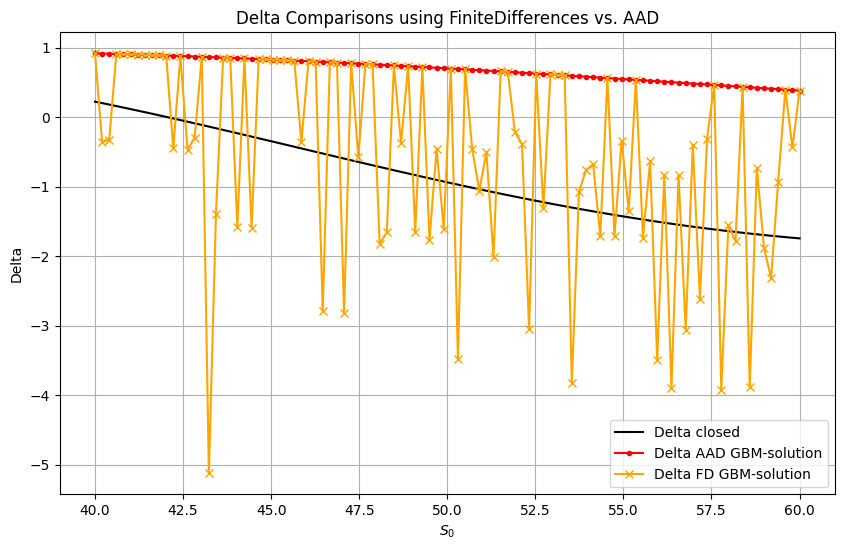

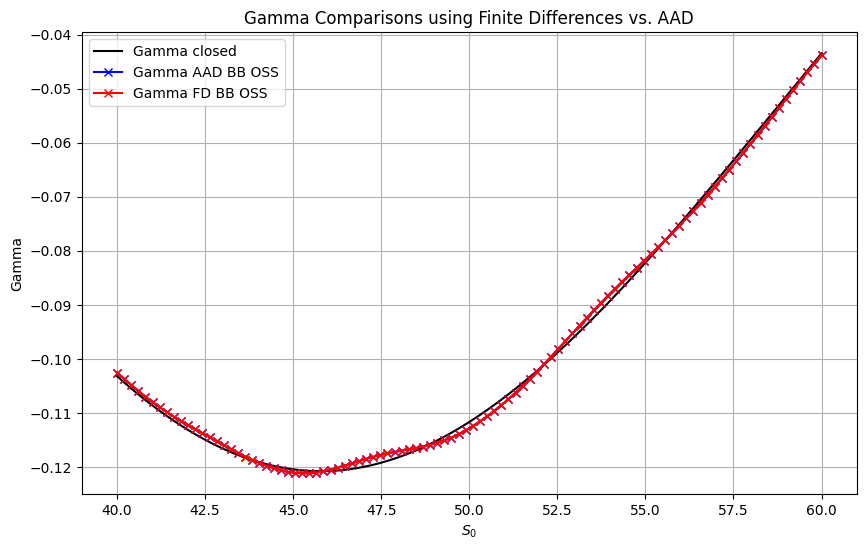

In [4]:
# Example array of s_0 values to test
s_0_values = np.linspace(40, 60, 100)
hDif = 0.0001

# Call the plotting function
#BarrierCall.plot_present_values(s_0_values)
BarrierCall.plot_deltas(s_0_values, hDif)
BarrierCall.plot_gammas(s_0_values, hDif)